# Классификация 128x128 + U-Net c бэкбоном

In [1]:
import os
from pathlib import Path

import random
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import json
import torch
import torch.nn as nn
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

# Import Utils.
from torch.utils.data import DataLoader
from src.utils.metrics import AverageMeter, CombinedLoss, dice_coefficient, iou_score, pixel_accuracy

# Import Datasets.
from src.datasets.MoonSegmentBinaryDataset import MoonSegmentationDataset

# Import models.
from src.models.model_utilizer import load_net
from src.models.customResNetUNet import customResNetUNet

from src.main import set_seed
from src.train import MetricsHistory

In [2]:
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version used by PyTorch: {torch.version.cuda}")
else:
    print("CUDA is not available. PyTorch is using CPU.")

CUDA is available!
Number of GPUs: 1
Current GPU Name: NVIDIA GeForce RTX 3060
CUDA Version used by PyTorch: 12.6


In [3]:
model_name = "customResNetUNet"

# Read config-files.
hyperparameters_dir = Path("./src/hyperparameters/")

config_path = hyperparameters_dir / "config.json"
assert config_path.exists(), f"Config not found: {config_path}"
with open(config_path, "r") as f:
    general_config = json.load(f)

set_seed(general_config.get("seed"))

model_config_path = hyperparameters_dir / f"{model_name}-config.json"
assert model_config_path.exists(), f"Config not found: {model_config_path}"
with open(model_config_path, "r") as f:
    model_config = json.load(f)

dataset_config_path = hyperparameters_dir / f"{model_config.get('dataset_name')}-config.json"
assert dataset_config_path.exists(), f"Config not found: {dataset_config_path}"
with open(dataset_config_path, "r") as f:
    dataset_config = json.load(f)
    
device = torch.device(general_config.get("device").lower() if torch.cuda.is_available() else 'cpu')
data_path = Path(general_config.get("data_dir")) / (model_config.get("dataset_name") + '/images')

In [4]:
checkpoints_file = Path('./checkpoints/customResNetUNet/best_customResNetUNet_backbone_pretrained_customResNet_4x2_classes_10_finetune_last_0_epochs.pth')

mdl_input_size = model_config.get('input_size')

model = customResNetUNet(
    in_channels = mdl_input_size[0],
    out_channels = 1,
    features = model_config.get('feature_list'),
    backbone_layers_config = model_config.get("backbone_layers_num")*[model_config.get("backbone_block_size")],
    backbone_layer0_channels = model_config.get('feature_list')[0],
    backbone_pretrained = False,
    backbone_checkpoints_file = None,
    device = device
    )

model, epoch, _, _ = load_net(
            net = model,
            checkpoints_file = checkpoints_file,
            device = device
            )

model.eval()

test_input = torch.randn(1, 3, 128, 128).to(device)
test_output = model(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

Encoder features by level: [18, 36, 72, 144]
Restoring checkpoint:  checkpoints\customResNetUNet\best_customResNetUNet_backbone_pretrained_customResNet_4x2_classes_10_finetune_last_0_epochs.pth
   Вход:  torch.Size([1, 3, 128, 128])
   Выход: torch.Size([1, 1, 128, 128])


In [5]:
mean_norm = [0.485, 0.456, 0.406]
std_norm = [0.229, 0.224, 0.225]

val_augmentation = A.Compose([
    A.Resize(*mdl_input_size[1:]),
])

preprocessing = A.Compose([
    A.Normalize(mean=mean_norm, std=std_norm),
    ToTensorV2(),
])  

img_prefix = dataset_config.get('img_prefix')
mask_prefix = dataset_config.get('mask_prefix')
img_folder = img_prefix + '/'
all_images = [img_no_ext.replace(img_prefix, '') for img_no_ext in
    [img.replace('.png', '') for img in sorted(os.listdir(data_path / img_folder)) if img.endswith('.png')]
]
train_images, val_images = train_test_split(
    all_images,
    test_size=0.2,
    random_state = general_config.get('seed'))

val_loader = DataLoader(
    MoonSegmentationDataset(
        data_path = data_path,
        samples = val_images,
        img_prefix = img_prefix,
        mask_prefix = mask_prefix,
        augmentation = val_augmentation,
        preprocessing = preprocessing
        ), 
    batch_size=model_config.get("batch_size"),
    shuffle=False,
    num_workers=model_config.get("workers"),
    pin_memory=True)

print(f"Valid. size: {len(val_loader.dataset)}")

Valid. size: 200


In [6]:
log_name = "customResNetUNet_backbone_pretrained_customResNet_4x2_classes_10_finetune_last_0_epochs"

log_dir = Path(general_config.get("logs_dir"))
with open(log_dir / (log_name + ".json"), "r") as f:
    full_data = json.load(f)
metadata = full_data.get("metadata")
train_log = full_data.get("train_log")

In [7]:
loss_func = CombinedLoss(bce_weight=0.5, dice_weight=0.5).to(device)

metrics = MetricsHistory()
metrics.initialize_metrics(
    ['loss', 'dice', 'iou', 'accuracy'],
    ['val']
    )

with torch.no_grad():
    for data_tuple in tqdm(val_loader, desc="Val"):
        
        inputs, masks = data_tuple[0].to(device), data_tuple[1].to(device)
        
        outputs = model(inputs)
        
        loss = loss_func(outputs, masks)

        metrics.update_metrics(
            split = "val",
            batch_size = inputs.size(0),
            loss = loss.item(),
            dice = dice_coefficient(outputs.detach(), masks.detach()),
            iou = iou_score(outputs.detach(), masks.detach()),
            accuracy = pixel_accuracy(outputs.detach(), masks.detach()))
        metrics.log_epoch_history(['val'])
metrics.print_metrics(['val'])
print(f"Loaded loss: {train_log[epoch-1].get('val_loss'):.4f}, dice: {train_log[epoch-1].get('val_dice'):.4f}, iou: {train_log[epoch-1].get('val_iou'):.4f}, accuracy: {train_log[epoch-1].get('val_accuracy'):.4f}")

Val: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]

Valid. loss: 0.4982, dice: 0.5397, iou: 0.3700, accuracy: 0.8946
Loaded loss: 0.4982, dice: 0.5397, iou: 0.3700, accuracy: 0.8946


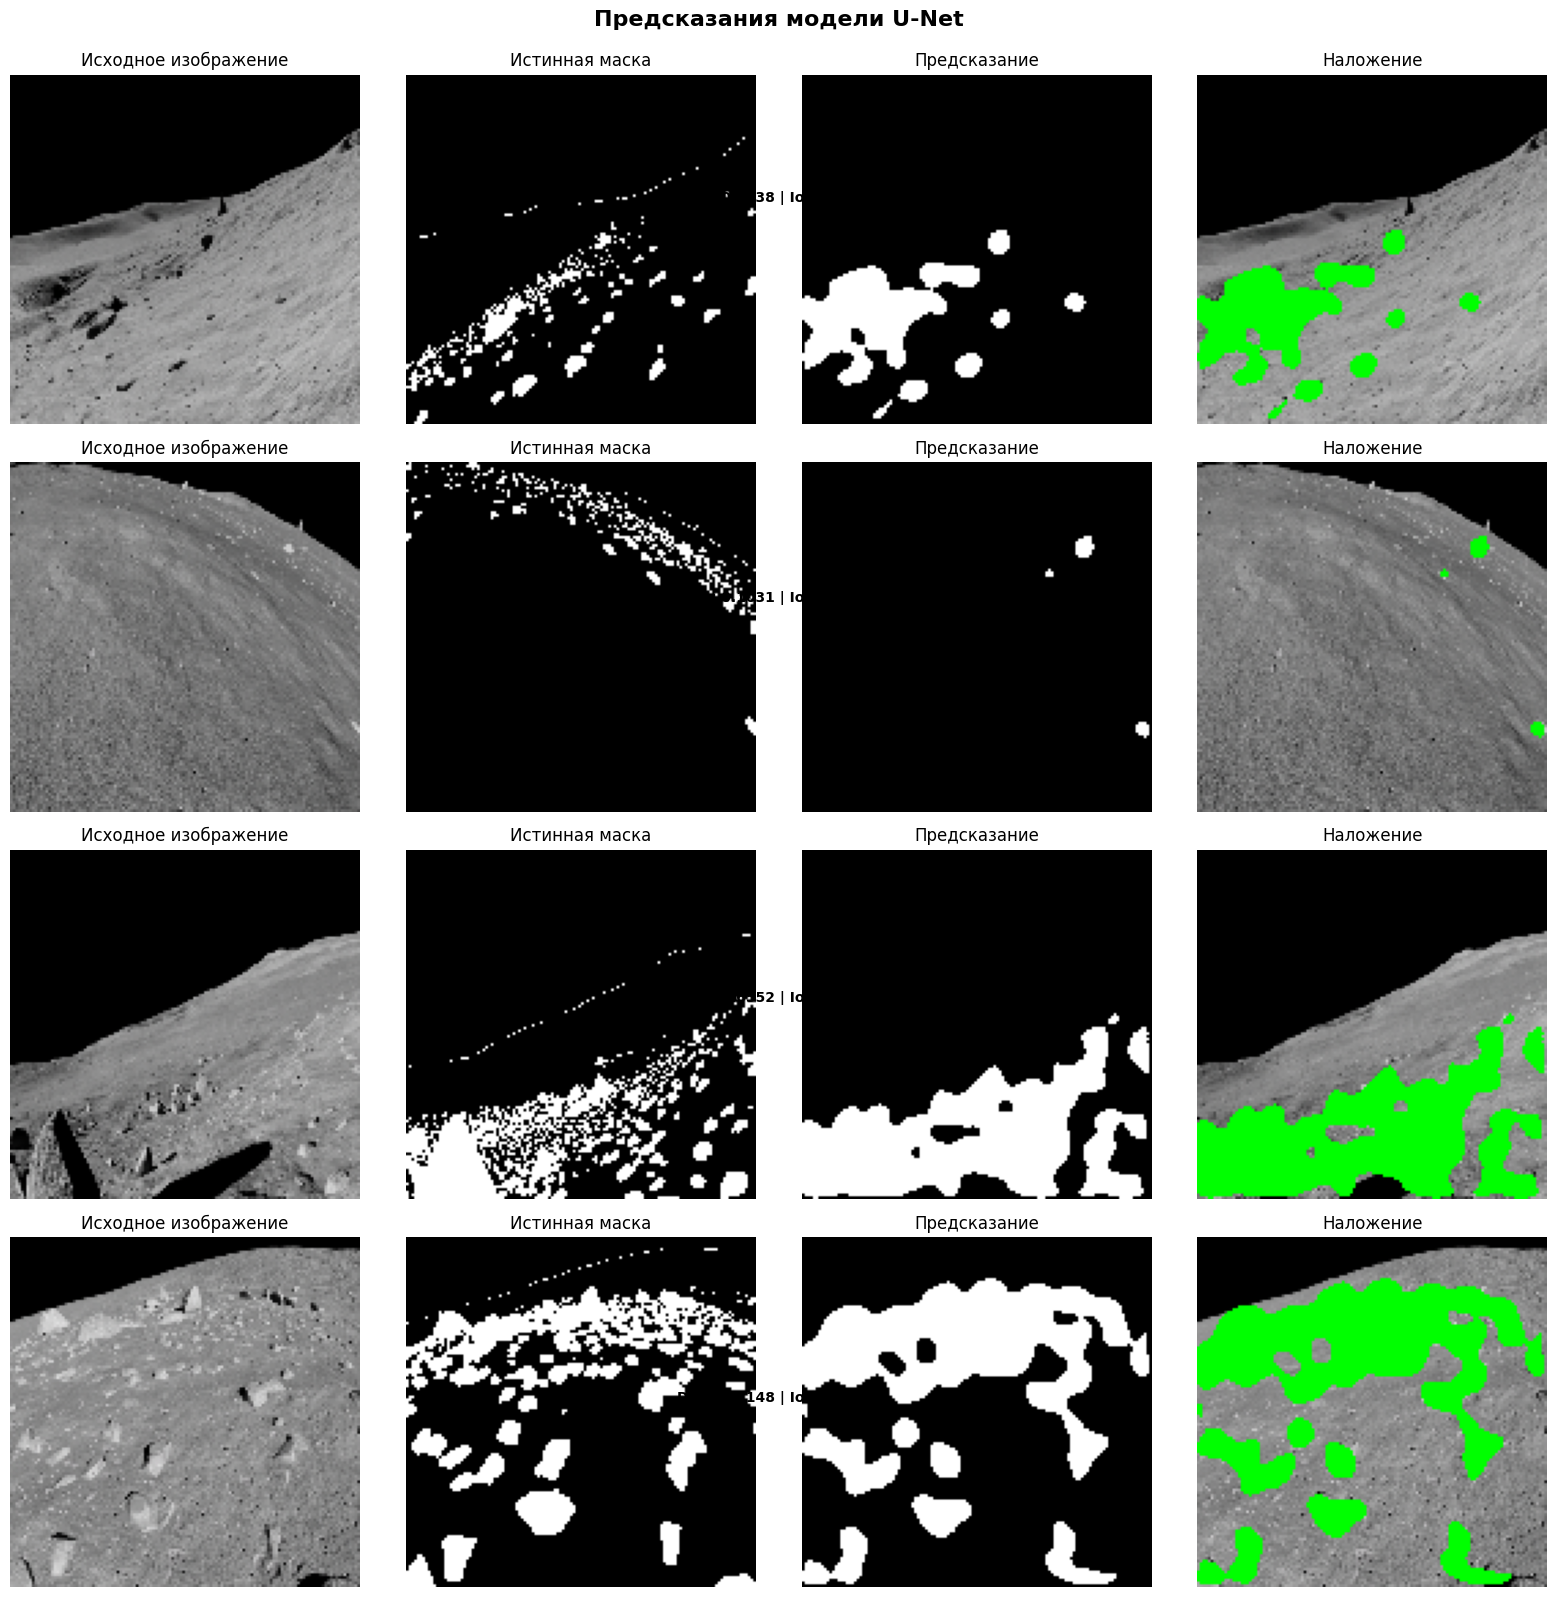

In [8]:
def denormalize(img_tensor):
    """Денормализация изображения для визуализации"""
    mean = torch.tensor(mean_norm).view(3, 1, 1)
    std = torch.tensor(std_norm).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

def visualize_predictions(model, dataloader, device, num_samples):

    model.eval()
    
    images, masks = next(iter(dataloader))
    
    with torch.no_grad():
        outputs = model(images.to(device))
        predictions = (outputs.detach() > 0.5).float()
    
    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        mask_true = masks[i, :, :].permute(1, 2, 0).numpy() 
        mask_pred = predictions[i, 0].numpy()
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное изображение', fontsize=12)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Истинная маска', fontsize=12)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(mask_pred, cmap='gray')
        axes[i, 2].set_title('Предсказание', fontsize=12)
        axes[i, 2].axis('off')
        
        overlay = img.copy()
        overlay[mask_pred > 0.5] = [0, 1, 0]
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Наложение', fontsize=12)
        axes[i, 3].axis('off')
        
        dice = dice_coefficient(outputs[i:i+1].cpu(), masks[i:i+1])
        iou = iou_score(outputs[i:i+1].cpu(), masks[i:i+1])
        
        fig.text(0.5, 1 - (i + 0.5) / num_samples, 
                f'Dice: {dice:.4f} | IoU: {iou:.4f}',
                ha='center', fontsize=10, fontweight='bold')
    
    plt.suptitle('Предсказания модели U-Net', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader, device, num_samples=4)

Размер батча изображений: torch.Size([100, 3, 128, 128])
Размер батча масок: torch.Size([100, 1, 128, 128])


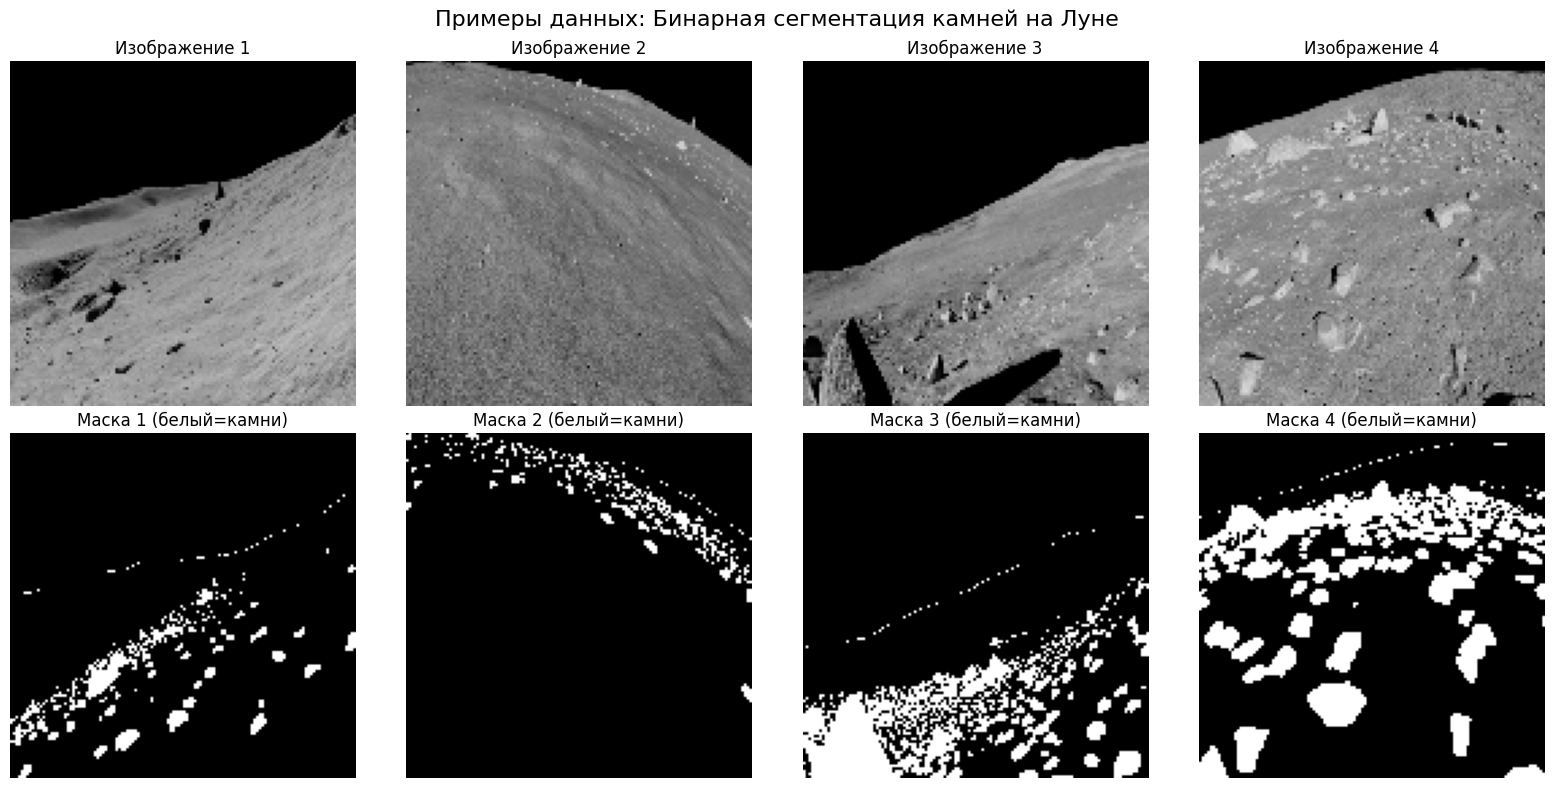

In [9]:
images, masks = next(iter(val_loader))

print(f"Размер батча изображений: {images.shape}")
print(f"Размер батча масок: {masks.shape}")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(min(4, len(images))):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    mask = masks[i].permute(1, 2, 0).numpy()
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Изображение {i+1}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f"Маска {i+1} (белый=камни)")
    axes[1, i].axis('off')

plt.suptitle("Примеры данных: Бинарная сегментация камней на Луне", fontsize=16)
plt.tight_layout()
plt.show()

Загрузка логов обучения.

In [10]:
from enum import IntEnum

# user-defined index.
class usid(IntEnum):
    mdl_4x2_ReLU_Adam = 0
    mdl_3x2_ReLU_Adam = 1
    mdl_3x1_ReLU_Adam = 2
    mdl_3x3_ReLU_Adam = 3
    mdl_3x2_Leaky_ReLU_Adam = 4
    mdl_3x2_ELU_Adam = 5
    mdl_3x2_GELU_Adam = 6
    mdl_3x2_ReLU_AdamW = 7

# Имена моделей.
model_names = [e.name for e in usid]

In [11]:
DATA_NUM = len(usid)

log_dir = Path("./train_logs/")
log_data = np.empty(DATA_NUM, dtype='object')
log_data_df = np.empty(DATA_NUM, dtype='object')
model_struct = np.empty(DATA_NUM, dtype='object')
for idx, name in enumerate(model_names):
    with open(log_dir / (name + ".json"), "r") as f:
        log_data[idx] = json.load(f)
        log_data_df[idx] = pd.DataFrame(log_data[idx].get("train_log"))
        model_struct[idx] = log_data[idx].get("model_architecture")

FileNotFoundError: [Errno 2] No such file or directory: 'train_logs\\mdl_4x2_ReLU_Adam.json'

Настройки форматирования графиков.

In [ ]:
user_figsize = (10, 6)
user_fontsize = 16
# legend_fontsize: 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'
line_type = ['-', ':']*len(model_names)
plot_mark = ['', 'o']

tab10_colors = [
    '#1f77b4',  # tab:blue
    '#ff7f0e',  # tab:orange
    '#2ca02c',  # tab:green
    '#d62728',  # tab:red
    '#9467bd',  # tab:purple
    '#8c564b',  # tab:brown
    '#e377c2',  # tab:pink
    '#7f7f7f',  # tab:gray
    '#bcbd22',  # tab:olive
    '#17becf']  # tab:cyan

plot_titles = ["Losses", "Accuracy"]
plot_legend = ['train', 'validation']
plot_xlabel = "epoch"
plot_ylabels = ["loss", "accuracy"]
METRIC_NUM = len(plot_titles)

## Часть 3: Поэтапная оптимизация модели

### 3.1. Оптимизация количества каналов

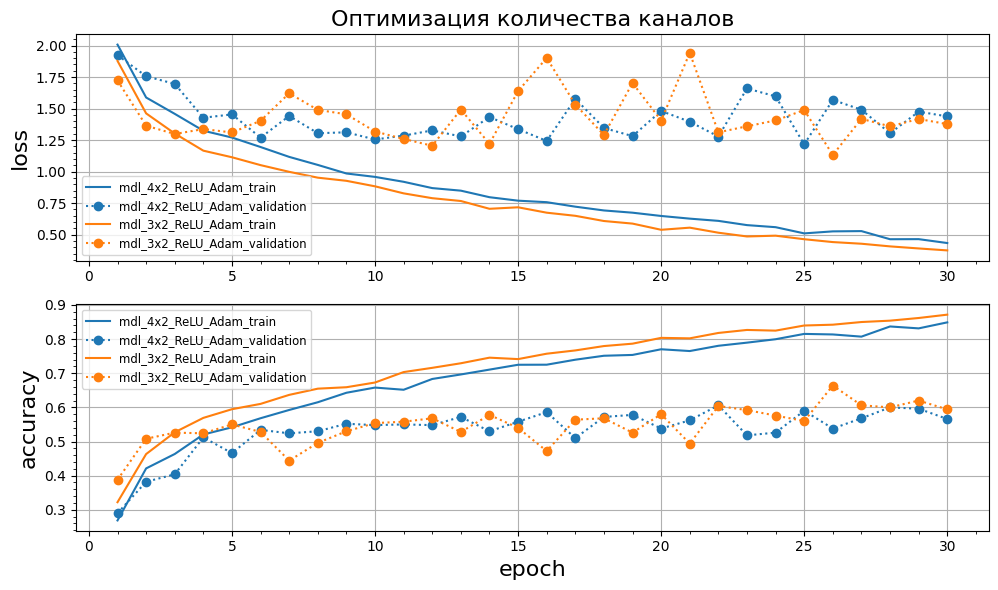

In [ ]:
plot_idx = [usid.mdl_4x2_ReLU_Adam.value, usid.mdl_3x2_ReLU_Adam.value]
plot_legend_local = []
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=user_figsize)
for k, ax in enumerate(axs):
    if k == 0:
        ax.set_title("Оптимизация количества каналов", fontsize=user_fontsize)
    else:
        ax.set_xlabel(plot_xlabel, fontsize=user_fontsize)
    for idx in plot_idx:
        for m in range(METRIC_NUM):
            ax.plot(
                log_data_df[idx].iloc[:,0], 
                log_data_df[idx].iloc[:,2*m+k+1],
                marker=plot_mark[m],
                linestyle=line_type[m],
                color=tab10_colors[idx]
                )
        plot_legend_local.extend([model_names[idx] + '_' + tp for tp in plot_legend])
    ax.set_ylabel(plot_ylabels[k], fontsize=user_fontsize)
    ax.legend(plot_legend_local, fontsize='small')
    ax.grid()
    ax.minorticks_on()
    
plt.tight_layout()
plt.savefig('readme_img/loss_acc_4x2_vs_3x2_ReLU_Adam.png', bbox_inches='tight')
plt.show()